In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
df = pd.read_csv('/kaggle/input/heart-attack-prediction-dataset/heart_attack_prediction_dataset.csv')
df.head()

,Patient ID,Age,Sex,Cholesterol,Blood Pressure,Heart Rate,Diabetes,Family History,Smoking,Obesity,...,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Heart Attack Risk
0,BMW7812,67,Male,208,158/88,72,0,0,1,0,...,6.615001,261404,31.251233,286,0,6,Argentina,South America,Southern Hemisphere,0
1,CZE1114,21,Male,389,165/93,98,1,1,1,1,...,4.963459,285768,27.194973,235,1,7,Canada,North America,Northern Hemisphere,0
2,BNI9906,21,Female,324,174/99,72,1,0,0,0,...,9.463426,235282,28.176571,587,4,4,France,Europe,Northern Hemisphere,0
3,JLN3497,84,Male,383,163/100,73,1,1,1,0,...,7.648981,125640,36.464704,378,3,4,Canada,North America,Northern Hemisphere,0
4,GFO8847,66,Male,318,91/88,93,1,1,1,1,...,1.514821,160555,21.809144,231,1,5,Thailand,Asia,Northern Hemisphere,0


# introduction
    This synthetic dataset provides a comprehensive array of features relevant to heart health and lifestyle choices, encompassing patient-specific details such as age, gender, cholesterol levels, blood pressure, heart rate, and indicators like diabetes, family history, smoking habits, obesity, and alcohol consumption. Additionally, lifestyle factors like exercise hours, dietary habits, stress levels, and sedentary hours are included. Medical aspects comprising previous heart problems, medication usage, and triglyceride levels are considered. Socioeconomic aspects such as income and geographical attributes like country, continent, and hemisphere are incorporated. The dataset, consisting of 8763 records from patients around the globe, culminates in a crucial binary classification feature denoting the presence or absence of a heart attack risk, providing a comprehensive resource for predictive analysis and research in cardiovascular health.

### Dataset Glossary (Column-wise- )
    - Patient ID: Unique identifier for each patient
    - Age: Age of the patient
    - Sex: Gender of the patient (Male/Female)
    - Cholesterol: Cholesterol levels of the patient
    - Blood Pressure: Blood pressure of the patient (systolic/diastolic)
    - Heart Rate: The heart rate of the patient
    - Diabetes: Whether the patient has diabetes (Yes/No)
    - Family History: Family history of heart-related problems (1: Yes, 0: No)
    - Smoking: Smoking status of the patient (1: Smoker, 0: Nonsmoker)
    - Obesity: Obesity status of the patient (1: Obese, 0: Not obese)
    - Alcohol Consumption: Level of alcohol consumption by the patient (None/Light/Moderate/Heavy)
    - Exercise Hours Per Week: Number of exercise hours per week
    - Diet: Dietary habits of the patient (Healthy/Average/Unhealthy)
    - Previous Heart Problems: Previous heart problems of the patient (1:Yes, 0:No)
    - Medication Use: Medication usage by the patient (1: Yes, 0: No)
    - Stress Level: Stress level reported by the patient (1-10)
    - Sedentary Hours Per Day: Hours of sedentary activity per day
    - Income: The income level of the patient
    - BMI: Body Mass Index (BMI) of the patient
    - Triglycerides: Triglyceride levels of the patient
    - Physical Activity Days Per Week: Days of physical activity per week
    - Sleep Hours Per Day: Hours of sleep per day
    - Country: Country of the patient
    - Continent: Continent where the patient resides
    - Hemisphere: Hemisphere where the patient resides
    - Heart Attack Risk: Presence of heart attack risk (1: Yes, 0: No)

In [ ]:
df.info()

In [ ]:
def data_info(data):
  cols=data.columns
  unique_val=[data[col].value_counts().head(10).index.to_numpy() for col in cols]
  n_uniques=[data[col].nunique() for col in cols]
  dtypes=[data[col].dtype for col in cols]
  nulls=[data[col].isnull().sum() for col in cols]
  dup=[data .duplicated().sum() for col in cols]
  return pd.DataFrame({"Col": cols, "Dtypes":dtypes, "N Uniques":n_uniques, "Null":nulls, "Uniques":unique_val, "duplicated":dup})


df_info = data_info(df)
df_info

In [ ]:
df.columns

In [3]:
# dropping the id feature because it's 100% unique
df.drop('Patient ID', axis=1, inplace=True)

### Exploratory Data Analysis

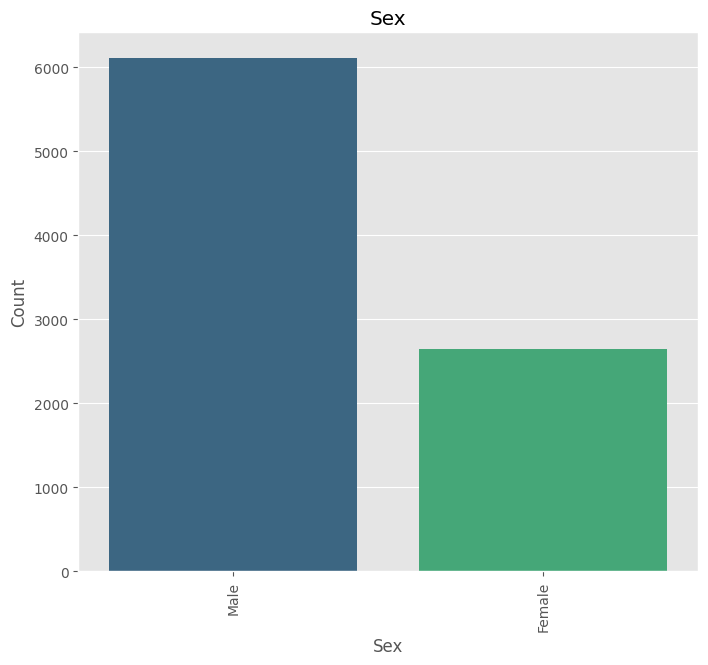

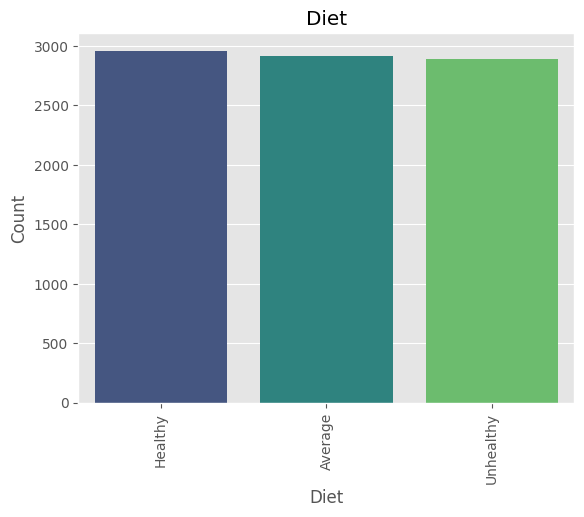

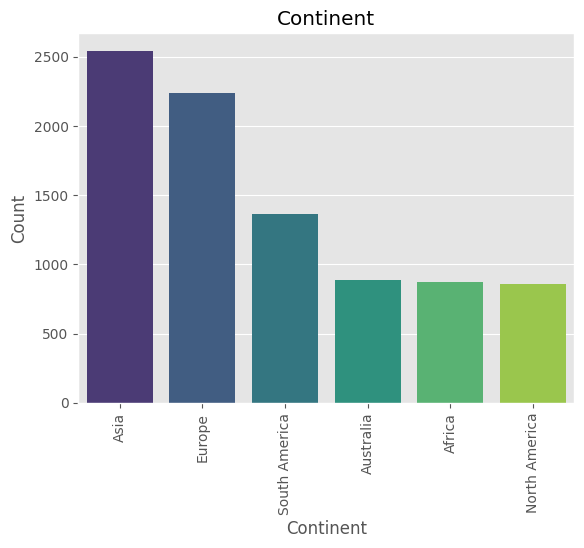

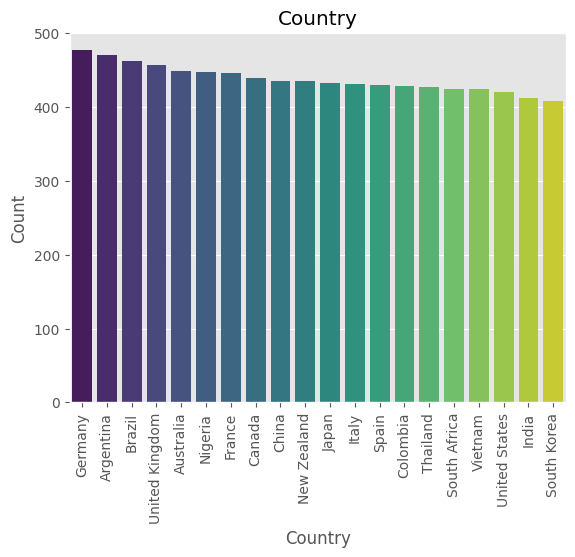

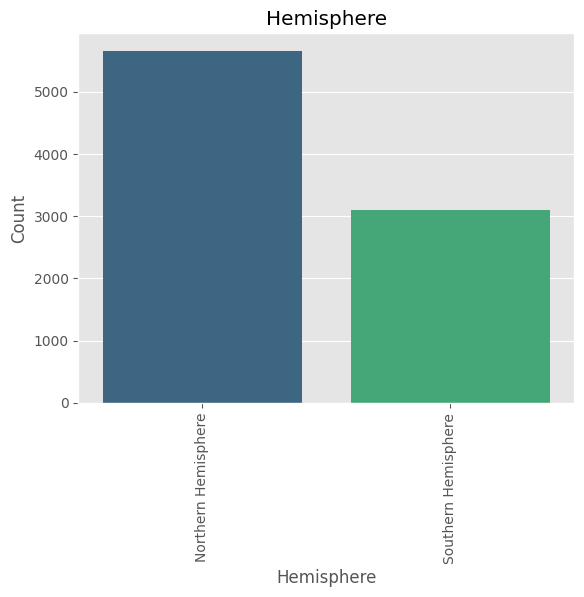

In [4]:
ctg_df = df[['Sex','Diet','Continent','Country','Hemisphere']]
plt.figure(figsize=(8, 7))
for i in ctg_df.columns:
    ctg_num = ctg_df[i].value_counts()
    chart = sns.barplot(x = ctg_num.index, y = ctg_num, palette='viridis')
    plt.title(i)
    plt.xlabel(i)
    plt.ylabel('Count')
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90, )
    plt.show()

### Correlation between Variables using HeatMap

<Axes: >

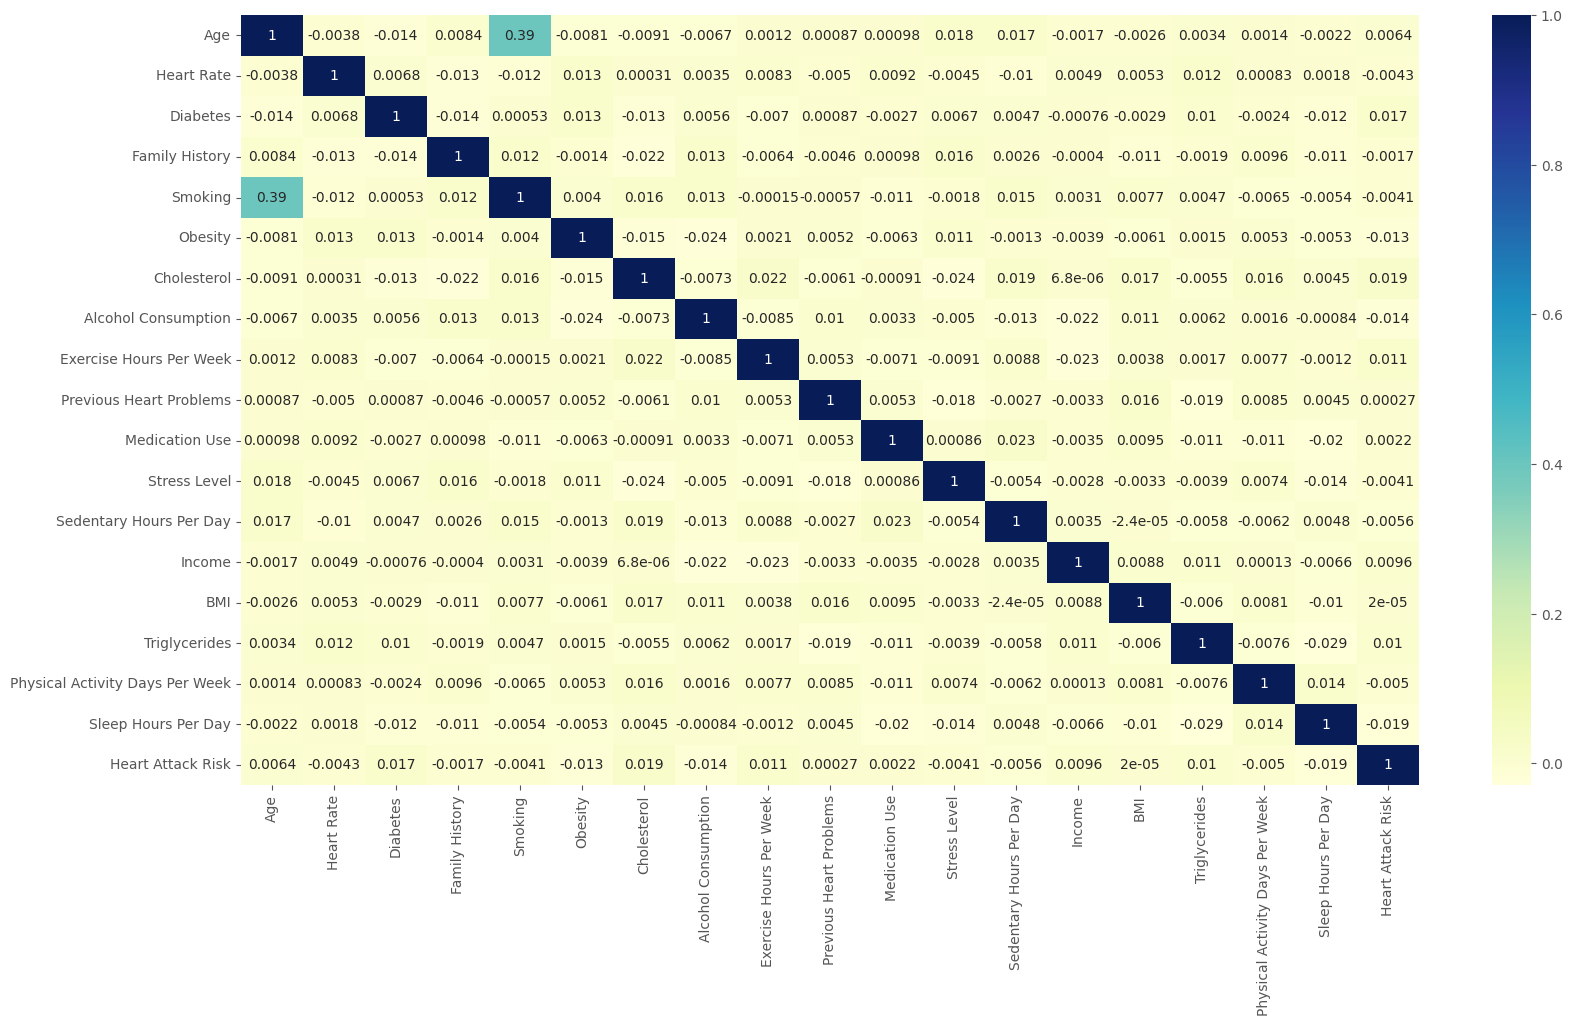

In [5]:
plt.figure(figsize = (19,10))
sns.heatmap(df[['Age','Heart Rate', 'Diabetes', 'Family History', 'Smoking', 'Obesity',
      'Cholesterol','Alcohol Consumption', 'Exercise Hours Per Week',
     'Previous Heart Problems', 'Medication Use', 'Stress Level',
       'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides',
       'Physical Activity Days Per Week', 'Sleep Hours Per Day','Heart Attack Risk']].corr(), cmap="YlGnBu",
            annot=True)

#### Key Findings

  - Heart Attack risk has highest correlation with Diabetes, Cholestrol and Exercise Hours Per Weak
  - Heart attack Risk is not much dependent on Sedentary Hours Per Day
  - Alcohol Consumption has no stronger link with Heart Attack Risk
  - Smoking is not a major cause of Heart Attack

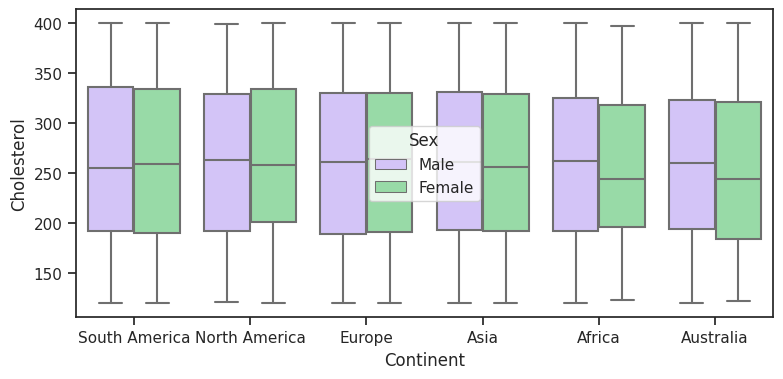

In [6]:
#Continents w.r.t Cholestrol Level range
plt.figure(figsize= (9,4))
sns.set_theme(style="ticks", palette="pastel")
sns.boxplot(x="Continent", y='Cholesterol', hue="Sex",
             palette=["m", "g"], data=df)
plt.show()


<Axes: xlabel='Continent', ylabel='Exercise Hours Per Week'>

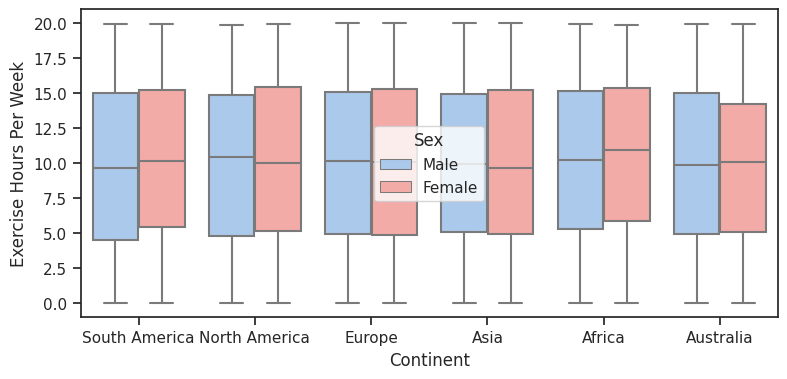

In [7]:
#Continents w.r.t Exercise Hours Per Week range
plt.figure(figsize= (9,4))
sns.set_theme(style="ticks", palette="pastel")
sns.boxplot(x="Continent", y='Exercise Hours Per Week',  hue="Sex",
             palette=["b", "r"], data=df)

#check outliers

In [ ]:
continuous_Features=["Age", "Cholesterol", "Heart Rate", "Exercise Hours Per Week",
                     "Sedentary Hours Per Day", "Income", "BMI", "Triglycerides"]

plt.figure(figsize=(15,15))
for column in range(len(continuous_Features)):
  plt.subplot(2,4,column+1)
  sns.boxenplot(df[continuous_Features[column]])
  plt.title(f"Box plot for {continuous_Features[column]}")
plt.show()

#Remove outliers

In [ ]:
for col in continuous_Features:
  Q1=df[col].quantile(0.25)
  Q3=df[col].quantile(0.75)
  IQR=Q3-Q1
  lower_bound=Q1-1.5*IQR
  upper_bound=Q3+1.5*IQR
  lower_outliers=df[df[col]<lower_bound][col].values
  upper_outliers=df[df[col]>upper_bound][col].values
  df[col].replace(lower_outliers,lower_bound,inplace=True)
  df[col].replace(upper_outliers,upper_bound,inplace=True)

## FEATURE ENGINEERING

- Setting column 'Blood Pressure'
Splitting Between Diastolic and Systolic Blood Pressure

In [8]:
df['BP_Systolic'] = df['Blood Pressure'].apply(lambda x: x.split('/')[0])
df['BP_Diastolic'] = df['Blood Pressure'].apply(lambda x: x.split('/')[1])

- Ordinal Encoding for diet: 1:healthy, 2:average, 3:unhealthy

In [9]:
oe_encoder = OrdinalEncoder(categories=[["Unhealthy", "Average", "Healthy"]])
df['Diet'] = oe_encoder.fit_transform(df[['Diet']])

- Lable encoding for 'Sex(Gender)

In [10]:
la = LabelEncoder()
df['Sex'] = la.fit_transform(df['Sex'])

In [11]:
df.dtypes

Age                                  int64
Sex                                  int64
Cholesterol                          int64
Blood Pressure                      object
Heart Rate                           int64
Diabetes                             int64
Family History                       int64
Smoking                              int64
Obesity                              int64
Alcohol Consumption                  int64
Exercise Hours Per Week            float64
Diet                               float64
Previous Heart Problems              int64
Medication Use                       int64
Stress Level                         int64
Sedentary Hours Per Day            float64
Income                               int64
BMI                                float64
Triglycerides                        int64
Physical Activity Days Per Week      int64
Sleep Hours Per Day                  int64
Country                             object
Continent                           object
Hemisphere 

- converting 'Object' Datatype into int

In [12]:
cat_columns = ['BP_Systolic','BP_Diastolic']
df[cat_columns] = df[cat_columns].astype(int)

In [13]:
df.dtypes

Age                                  int64
Sex                                  int64
Cholesterol                          int64
Blood Pressure                      object
Heart Rate                           int64
Diabetes                             int64
Family History                       int64
Smoking                              int64
Obesity                              int64
Alcohol Consumption                  int64
Exercise Hours Per Week            float64
Diet                               float64
Previous Heart Problems              int64
Medication Use                       int64
Stress Level                         int64
Sedentary Hours Per Day            float64
Income                               int64
BMI                                float64
Triglycerides                        int64
Physical Activity Days Per Week      int64
Sleep Hours Per Day                  int64
Country                             object
Continent                           object
Hemisphere 

In [14]:
df.drop(['Blood Pressure', 'Hemisphere', 'Continent', 'Country'], axis=1, inplace=True)
df.head()

,Age,Sex,Cholesterol,Heart Rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk,BP_Systolic,BP_Diastolic
0,67,1,208,72,0,0,1,0,0,4.168189,...,9,6.615001,261404,31.251233,286,0,6,0,158,88
1,21,1,389,98,1,1,1,1,1,1.813242,...,1,4.963459,285768,27.194973,235,1,7,0,165,93
2,21,0,324,72,1,0,0,0,0,2.078353,...,9,9.463426,235282,28.176571,587,4,4,0,174,99
3,84,1,383,73,1,1,1,0,1,9.828130,...,9,7.648981,125640,36.464704,378,3,4,0,163,100
4,66,1,318,93,1,1,1,1,0,5.804299,...,6,1.514821,160555,21.809144,231,1,5,0,91,88


In [15]:
df.duplicated().sum()

0

In [16]:
x = df.drop('Heart Attack Risk', axis=1)
y = df['Heart Attack Risk']

In [17]:
x.head()

,Age,Sex,Cholesterol,Heart Rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,BP_Systolic,BP_Diastolic
0,67,1,208,72,0,0,1,0,0,4.168189,...,0,9,6.615001,261404,31.251233,286,0,6,158,88
1,21,1,389,98,1,1,1,1,1,1.813242,...,0,1,4.963459,285768,27.194973,235,1,7,165,93
2,21,0,324,72,1,0,0,0,0,2.078353,...,1,9,9.463426,235282,28.176571,587,4,4,174,99
3,84,1,383,73,1,1,1,0,1,9.828130,...,0,9,7.648981,125640,36.464704,378,3,4,163,100
4,66,1,318,93,1,1,1,1,0,5.804299,...,0,6,1.514821,160555,21.809144,231,1,5,91,88


# spliting data

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

#scaling

In [19]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [20]:
model1 = GaussianNB()
model1.fit(x_train, y_train)

GaussianNB()

In [21]:
y_pred=model1.predict(x_test)
accuracy_score(y_test,y_pred)

0.6417569880205363

In [22]:
model2 = DecisionTreeClassifier()
model2.fit(x_train, y_train)

DecisionTreeClassifier()

In [23]:
y_pred=model2.predict(x_test)
accuracy_score(y_test,y_pred)

0.5453508271534512

In [24]:
model3 = RandomForestClassifier()
model3.fit(x_train, y_train)

RandomForestClassifier()

In [25]:
y_pred=model3.predict(x_test)
accuracy_score(y_test,y_pred)

0.6383342840844267

In [26]:
model4 = KNeighborsClassifier()
model4.fit(x_train, y_train)

KNeighborsClassifier()

In [27]:
y_pred=model4.predict(x_test)
accuracy_score(y_test,y_pred)

0.573873359954364

- Tuning parameter

In [28]:
Knn=KNeighborsClassifier()
param_grid={
    "n_neighbors":[100,1000],
    "p":[1,2]
}
grid_search=GridSearchCV(Knn,param_grid,cv=5)
grid_search.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [100, 1000], 'p': [1, 2]})

In [29]:
grid_search.best_estimator_

KNeighborsClassifier(n_neighbors=1000, p=1)

In [30]:
best_knn=grid_search.best_estimator_
y_pred=best_knn.predict(x_test)
accuracy_score(y_test,y_pred)

0.6417569880205363

In [31]:
import joblib

In [32]:
joblib.dump(model4, 'KNeighborsClassifier.pkl')

['KNeighborsClassifier.pkl']